# GEOG 5160 6160 Lab 05

# Introduction

A frequent accusation of machine models is that they are 'black-box'; that they are so complex, it is difficult or impossible to understand how they work. In response to this, there is a growth of *interpretable* or explainable machine learning methods, designed to shed some light on the inner workings of these models. These methods provide a way to understand biases in models, but can also be useful explanatory methods to help understand your dataset.

In this lab, we'll explore the use of the methods for both global and local interpretation using a data set of bike rentals. The goal of this exercise is to predict the number of expected rentals for any given day based on a series of factors, including season, day of the week, weather, etc. (full details in appendix 1). The data are in the file *bike.csv*, which you should download and move to a working folder for this lab.

## Objectives

- Understand how to convert use methods for global and local interpretation
- Revisit tuning models in this lab.

You will need to make sure the following packages are installed on your computer (in addition to the packages we have used in previous labs). 

- **pdpbox**: improved partial dependency plots
- **shap**: Calculate and visualize Shapley values
- **lime**: Calculate and visualize local models (LIME)

## Data processing

Let's start by by importing the modules we'll need for the class, then we'll go get the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's load the bike rental data first and take a look at the content:

In [2]:
bike = pd.read_csv("./datafiles/bike.csv")
bike.shape

(731, 12)

In [3]:
from skimpy import skim

skim(bike)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 731    │ │ string      │ 6     │                                                          │
│ │ Number of columns │ 12     │ │ int64       │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 3     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column             ┃ NA  ┃ NA %  ┃ mean   ┃ sd      ┃ p0      ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ yr                 │   0 │     0 │   2012 │  0.5003 │    2011 │   2011 │   2012 │   2012 │   2012 │ █    █ │  │
│ │ temp               │   0 │     0 │  15.28 │   8.603 │  -5.221 │  7.843 │  15.42 │   22.8 │   32.5 │ ▁▆▇▆█▃ │  │
│ │ hum                │   0 │     0 │  62.79 │   14.24 │       0 │     52 │  62.67 │  73.02 │  97.25 │   ▃█▇▂ │  │
│ │ windspeed          │   0 │     0 │  12.76 │   5.192 │     1.5 │  9.042 │  12.13 │  15.63 │     34 │ ▂█▆▂▁  │  │
│ │ count              │   0 │     0 │   4504 │    1937 │      22 │   3152 │   4548 │   5956 │   8714 │ ▂▅▇█▅▃ │  │
│ │ days_since_2011    │   0 │     0 │    365 │   211.2 │       0 │  182.5 │    365 │  547.5 │    730 │ ██████ │  │
│ └────────────────────┴─────┴───────┴────────┴─────────┴─────────┴────────┴────────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃           ┃    ┃      ┃           ┃           ┃           ┃           ┃ chars per ┃ words per  ┃ total     ┃  │
│ ┃ column    ┃ NA ┃ NA % ┃ shortest  ┃ longest   ┃ min       ┃ max       ┃ row       ┃ row        ┃ words     ┃  │
│ ┡━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ season    │  0 │    0 │ FALL      │ WINTER    │ FALL      │ WINTER    │      5.51 │          1 │       731 │  │
│ │ mnth      │  0 │    0 │ JAN       │ JAN       │ APR       │ SEP       │         3 │          1 │       731 │  │
│ │ holiday   │  0 │    0 │ HOLIDAY   │ NO        │ HOLIDAY   │ NO        │      9.91 │          2 │      1441 │  │
│ │           │    │      │           │ HOLIDAY   │           │ HOLIDAY   │           │            │           │  │
│ │ weekday   │  0 │    0 │ SAT       │ SAT       │ FRI       │ WED       │         3 │          1 │       731 │  │
│ │ workingda │  0 │    0 │ WORKING   │ NO        │ NO        │ WORKING   │      11.9 │        2.3 │      1693 │  │
│ │ y         │    │      │ DAY       │ WORKING   │ WORKING   │ DAY       │           │            │           │  │
│ │           │    │      │           │ DAY       │ DAY       │           │           │            │           │  │
│ │ weathersi │  0 │    0 │ GOOD      │ RAIN/SNOW │ GOOD      │ RAIN/SNOW │      4.65 │          1 │       731 │  │
│ │ t         │    │      │           │ /STORM    │     

Now let's make a couple of figures. First, we'll plot the rentals over time (`days_since_2011`)

Text(0, 0.5, 'Rentals')

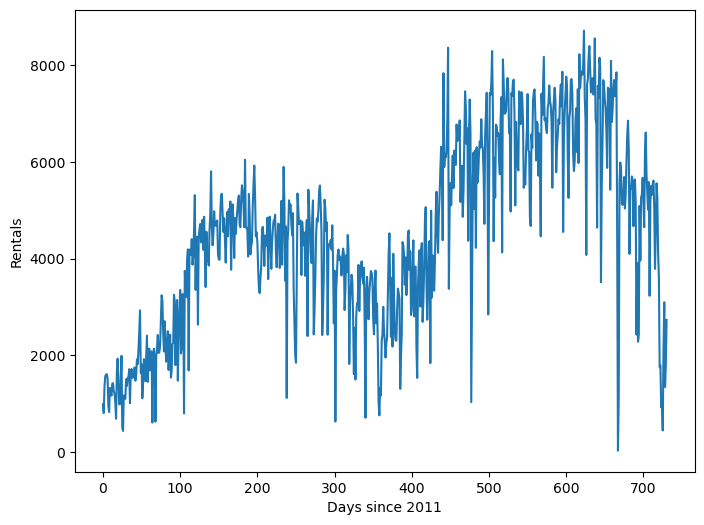

In [4]:
plt.figure(figsize=(8,6))
plt.plot(bike['days_since_2011'], bike['count'])
plt.xlabel("Days since 2011")
plt.ylabel("Rentals")

There's a fairly upward trend in the data, as the rental service became more popular over time. To avoid this, we'll just work with the second year of data (2012). We'll then make the `X` and `y` arrays, by dropping the year and `days_since_2011` columns. The data also contain both a `season` and month (`mnth`) feature, which are likely redundant. We'll drop the month here.

In [5]:
bike = bike[bike["yr"]==2012]
bike.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'count', 'days_since_2011'],
      dtype='object')

In [6]:
sel_features = ['season', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed']
X = bike[sel_features]
y = bike['count']

And we'll one-hot encode the categorical features (`season`, `holiday`, `weekday`, `workingday`, and `weathersit`)

In [7]:
X = pd.get_dummies(X, dtype=int, drop_first=True)

In [8]:
X.head()

temp      hum  windspeed  season_SPRING  season_SUMMER  \
365  9.390000  69.2500  12.875189              0              0   
366  4.833021  38.1304  22.087555              0              0   
367 -0.950000  44.1250  24.499957              0              0   
368 -2.947500  41.4583  12.374900              0              0   
369  4.494151  52.4167   8.709129              0              0   

     season_WINTER  holiday_NO HOLIDAY  weekday_MON  weekday_SAT  weekday_SUN  \
365              1                   1            0            0            1   
366              1                   0            1            0            0   
367              1                   1            0            0            0   
368              1                   1            0            0            0   
369              1                   1            0            0            0   

     weekday_THU  weekday_TUE  weekday_WED  workingday_WORKING DAY  \
365            0            0            0                       0   
366            0            0            0                       0   
367            0            1            0                       1   
368            0            0            1                       1   
369            1            0            0                       1   

     weathersit_MISTY  weathersit_RAIN/SNOW/STORM  
365                 0                           0  
366                 0                           0  
367                 0                           0  
368                 1                           0  
369                 0                           0

## Base model

Next, let's develop a model for these data. We'll use a random forest here. First, let's set up and train a model without tuning. We'll go through the usual steps to set up:

- Split the data into training and testing (holdout, 20% in testing)
- Instantiate and fit a random forest model
- Test predictions using the RMSE

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8, 
                                                    shuffle=True, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [11]:
y_test_pred = rf.predict(X_test)

from sklearn.metrics import root_mean_squared_error
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 693.90


Giving an RMSE of a little under 700 (your value will likely be different).

## Tuning

Now let's tune this model to get the optimal hyperparameter set. Here are the steps to set this up:

-   Define the grid (the values of each hyperparameter to test). We'll use a very similar grid to the previous example
-   Define the tuning specification (the model and hyperparameters, scoring metric)
-   Define the cross-validation strategy for tuning

In [12]:
rf_param = {'n_estimators':[100,200,300,400,500],
             'max_features':[2,4,6,8,10],
               'min_samples_leaf': [4]}

In [13]:
from sklearn.model_selection import GridSearchCV

rf_tuned = GridSearchCV(RandomForestRegressor(), 
                        rf_param, 
                        scoring='neg_mean_squared_error', 
                        cv=5, n_jobs=-1)
rf_tuned.fit(X_train, y_train)
print(rf_tuned.cv_results_['mean_test_score'])

[-1148715.19002976 -1151772.84481718 -1151849.23250398 -1141864.13644869
 -1138669.8628495   -871394.92116041  -857366.73397532  -866468.61662983
  -857191.49905621  -862256.48581032  -789213.11763596  -785367.19448476
  -780997.78470053  -793872.70861776  -788970.70557729  -753293.14689435
  -770034.82885362  -767203.26165903  -765496.72511533  -760884.61942919
  -763166.19915335  -749594.19470688  -749547.88958035  -752268.80586471
  -750970.55087505]


Once run, let's explore the results

In [14]:
print(rf_tuned.best_estimator_)
print(rf_tuned.best_score_)

RandomForestRegressor(max_features=10, min_samples_leaf=4, n_estimators=300)
-749547.8895803511


And finally test the tuned model. Note here that we do not get any improvement over the base model. 

In [15]:
y_test_pred = rf_tuned.predict(X_test)

from sklearn.metrics import root_mean_squared_error
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 752.52


# Interpretable machine learning

We'll now explore the random forest we built. We'll used the tuned model here, but given how close the results were, we could also use the base model. Most of the initial exploration we'll do will be based on **scikit-learn** functions, but we'll also use some additional packages as we go. 

## Global measures

We'll start by looking at global methods for ML interpretation. As a reminder, these are methods that evaluate the model in aggregate across the full set of observations and features.

### Feature/variable importance

We've looked at feature importance scores in the last two labs. These are measures of how useful a variable is in predicting the target. In previous labs, we've used the feature importance calculated as part of the random forest training (impurity-based importance). An alternative approach uses the `permutation_importance` function. This is a model-agnostic approach, that can be used with any algorithm. Here, each feature is randomly shuffled in turn, and the loss in predictive power is calculated. Bigger losses indicate that a higher level of importance. As each permutation is random, we can repeat this several times (`n_times`). The changes in the importance score from each permutation can then be used to add uncertainty to the scores

In [16]:
from sklearn.inspection import permutation_importance
vip = permutation_importance(rf_tuned, X_train, y_train,
                             n_repeats=30,
                             random_state=0)

Let's extract the mean importance and it's standard deviation, sort and print

In [17]:
var_names = X.columns
importances = vip.importances_mean
imp_std = vip.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], var_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 0 temp (2548835.273070)
2. feature 1 hum (564229.499276)
3. feature 5 season_WINTER (506468.353029)
4. feature 2 windspeed (172692.532734)
5. feature 14 weathersit_MISTY (70655.203735)
6. feature 3 season_SPRING (40346.508029)
7. feature 13 workingday_WORKING DAY (30284.397077)
8. feature 4 season_SUMMER (14993.582833)
9. feature 9 weekday_SUN (12163.249576)
10. feature 8 weekday_SAT (11885.560264)
11. feature 7 weekday_MON (10772.105209)
12. feature 11 weekday_TUE (2336.293514)
13. feature 10 weekday_THU (1049.003744)
14. feature 12 weekday_WED (912.167107)
15. feature 6 holiday_NO HOLIDAY (352.411397)
16. feature 15 weathersit_RAIN/SNOW/STORM (0.000000)


And finally, plot the importance values as a bar chart, which clearly shows temperature as being the most influential feature for bike rentals.


<BarContainer object of 16 artists>

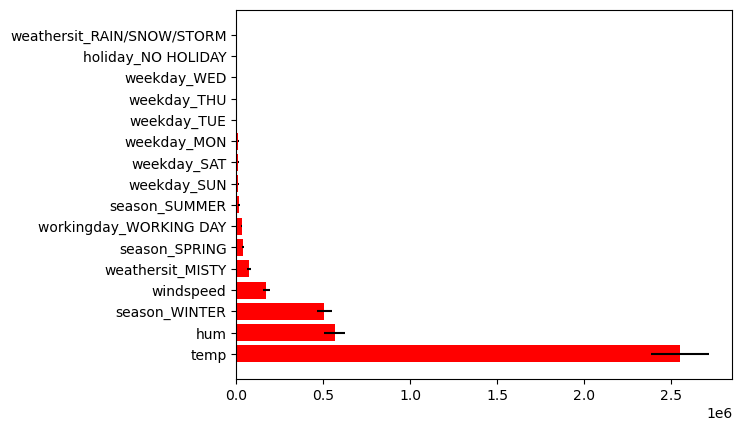

In [18]:
plt.barh(np.array(var_names)[indices], 
        importances[indices],
        xerr = imp_std[indices],
        color="r", align="center")

### Partial dependence

We used partial dependency curves in a previous lab with the tree-based methods. These are considered to be a global interpretation method as they show the *average* response of the model over the range of a given feature. We'll use these here to plot the partial dependency of temperature and humidity:

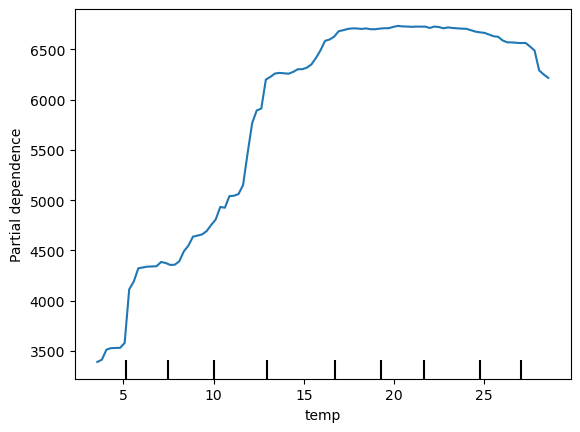

In [19]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, ['temp'])

The response seems pretty logical. Rentals increase as temperatures increase up to a maximum around 25 celsius. Beyond this, there is a slight decline at hotter temperatures. 

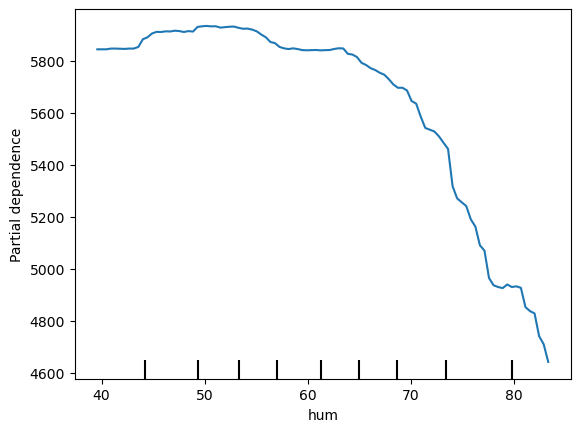

In [20]:
PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, ['hum'])

Here we can see that humidity values below about 60% have little impact on the rentals, but there is a fairly sharp drop off above this value. We can look at the combined effect of temperature and humidity with the same object, which clearly shows the sweet spot for bike rentals when temperatures are around 25 degrees and humidity around 55% (and the low rentals at low temp/high humidity). 

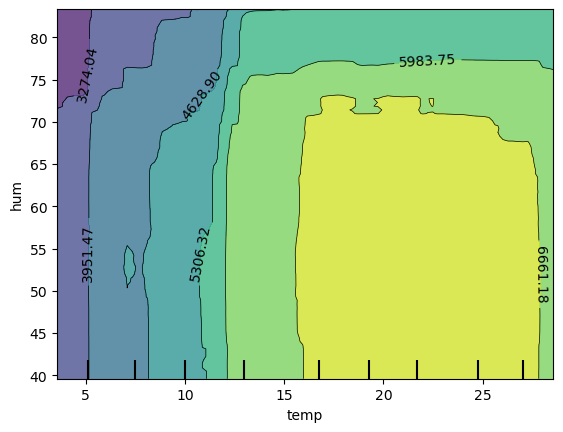

In [21]:
PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, [['temp','hum']])

We can also plot the partial dependency for a categorical feature. The following shows the decline in expected rentals for rainy or snowy days:

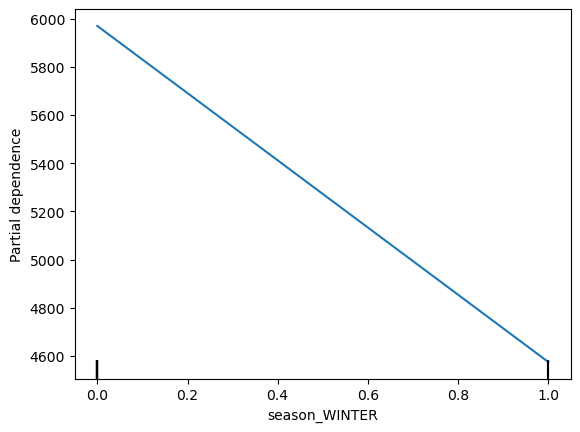

In [44]:
PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, ['season_WINTER'])

To get nicer partial dependency plots, we can use the **pdpbox** package. This requires two steps:

- First extract the necessary data and model output using `PDPIsolate`
- Plot it

/opt/homebrew/Caskroom/miniforge/base/envs/geog5160/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 231.94it/s]


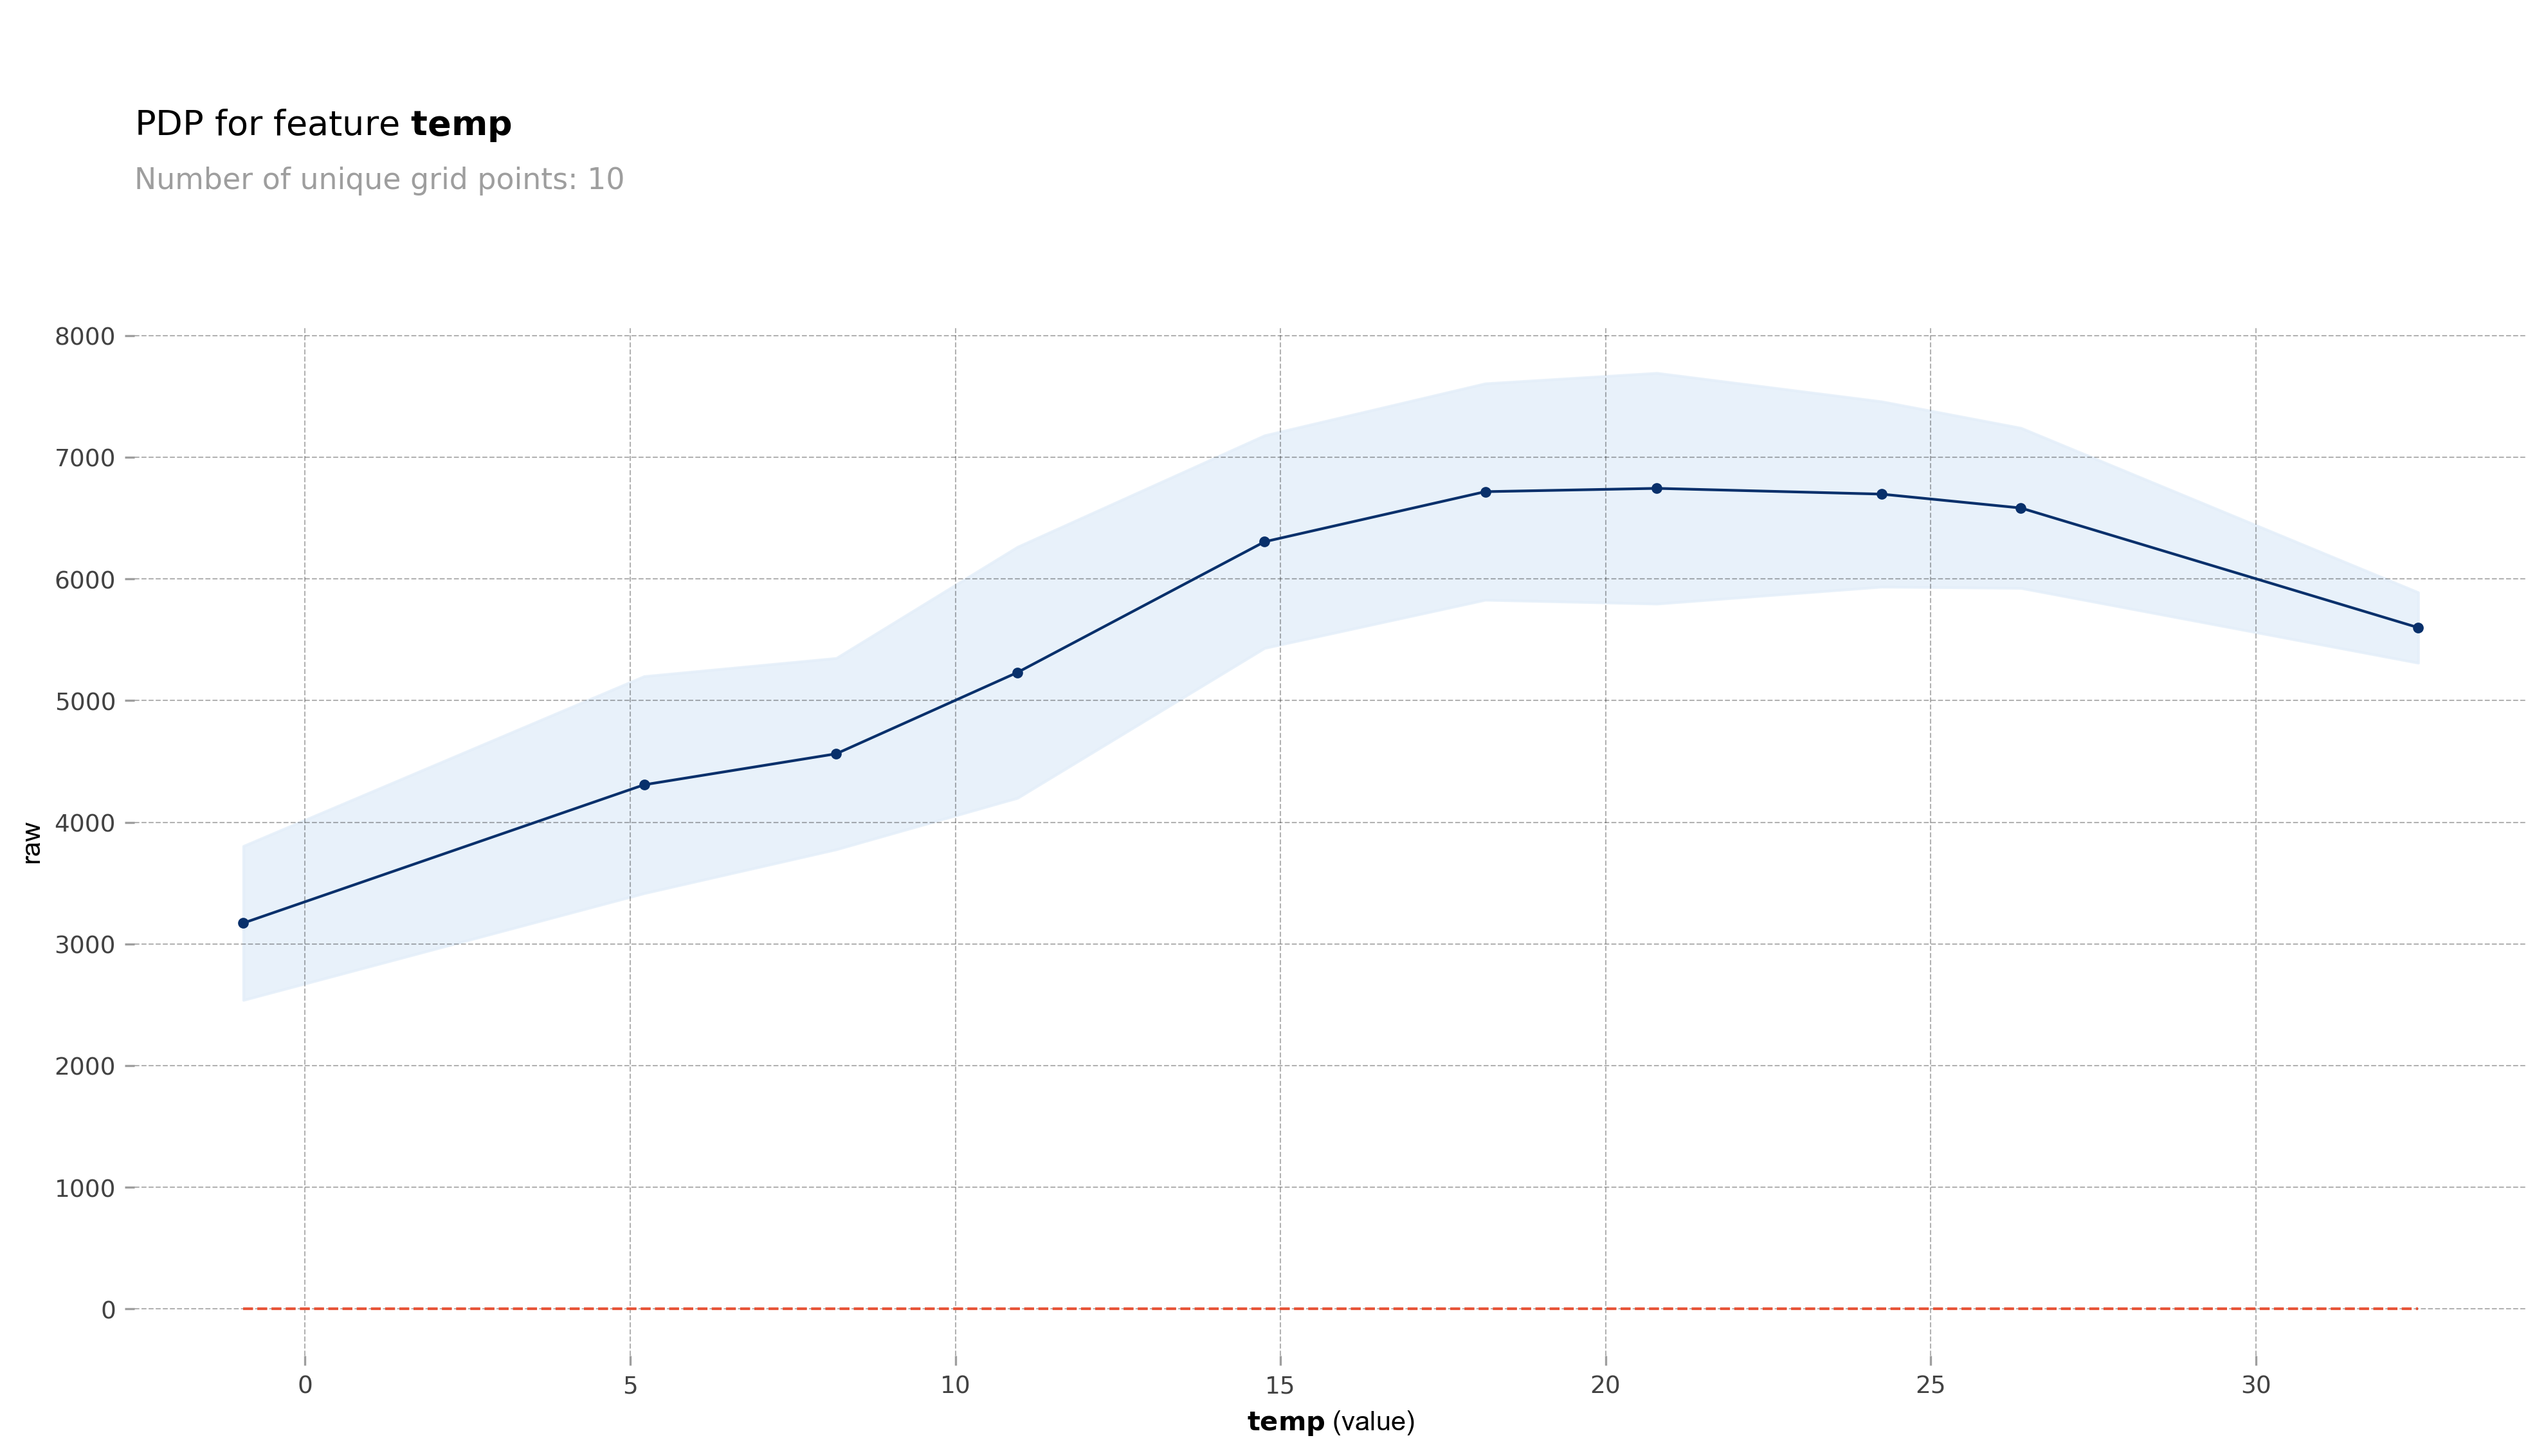

In [23]:
from pdpbox import pdp

feature_to_plot = 'temp'
pdp_dist = pdp.PDPIsolate(model=rf, df=X_train.copy(), model_features=X_train.columns, 
                          feature=feature_to_plot, feature_name=feature_to_plot, n_classes=0)
fig, axes = pdp_dist.plot(engine='matplotlib', plot_lines=False, center=False, show_percentile=True)

And you can make 2D partial dependency plots with `PDPInteract`

obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 251.59it/s]


obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 225.07it/s]


obtain pred_func from the provided model.


100%|██████████| 100/100 [00:00<00:00, 271.29it/s]


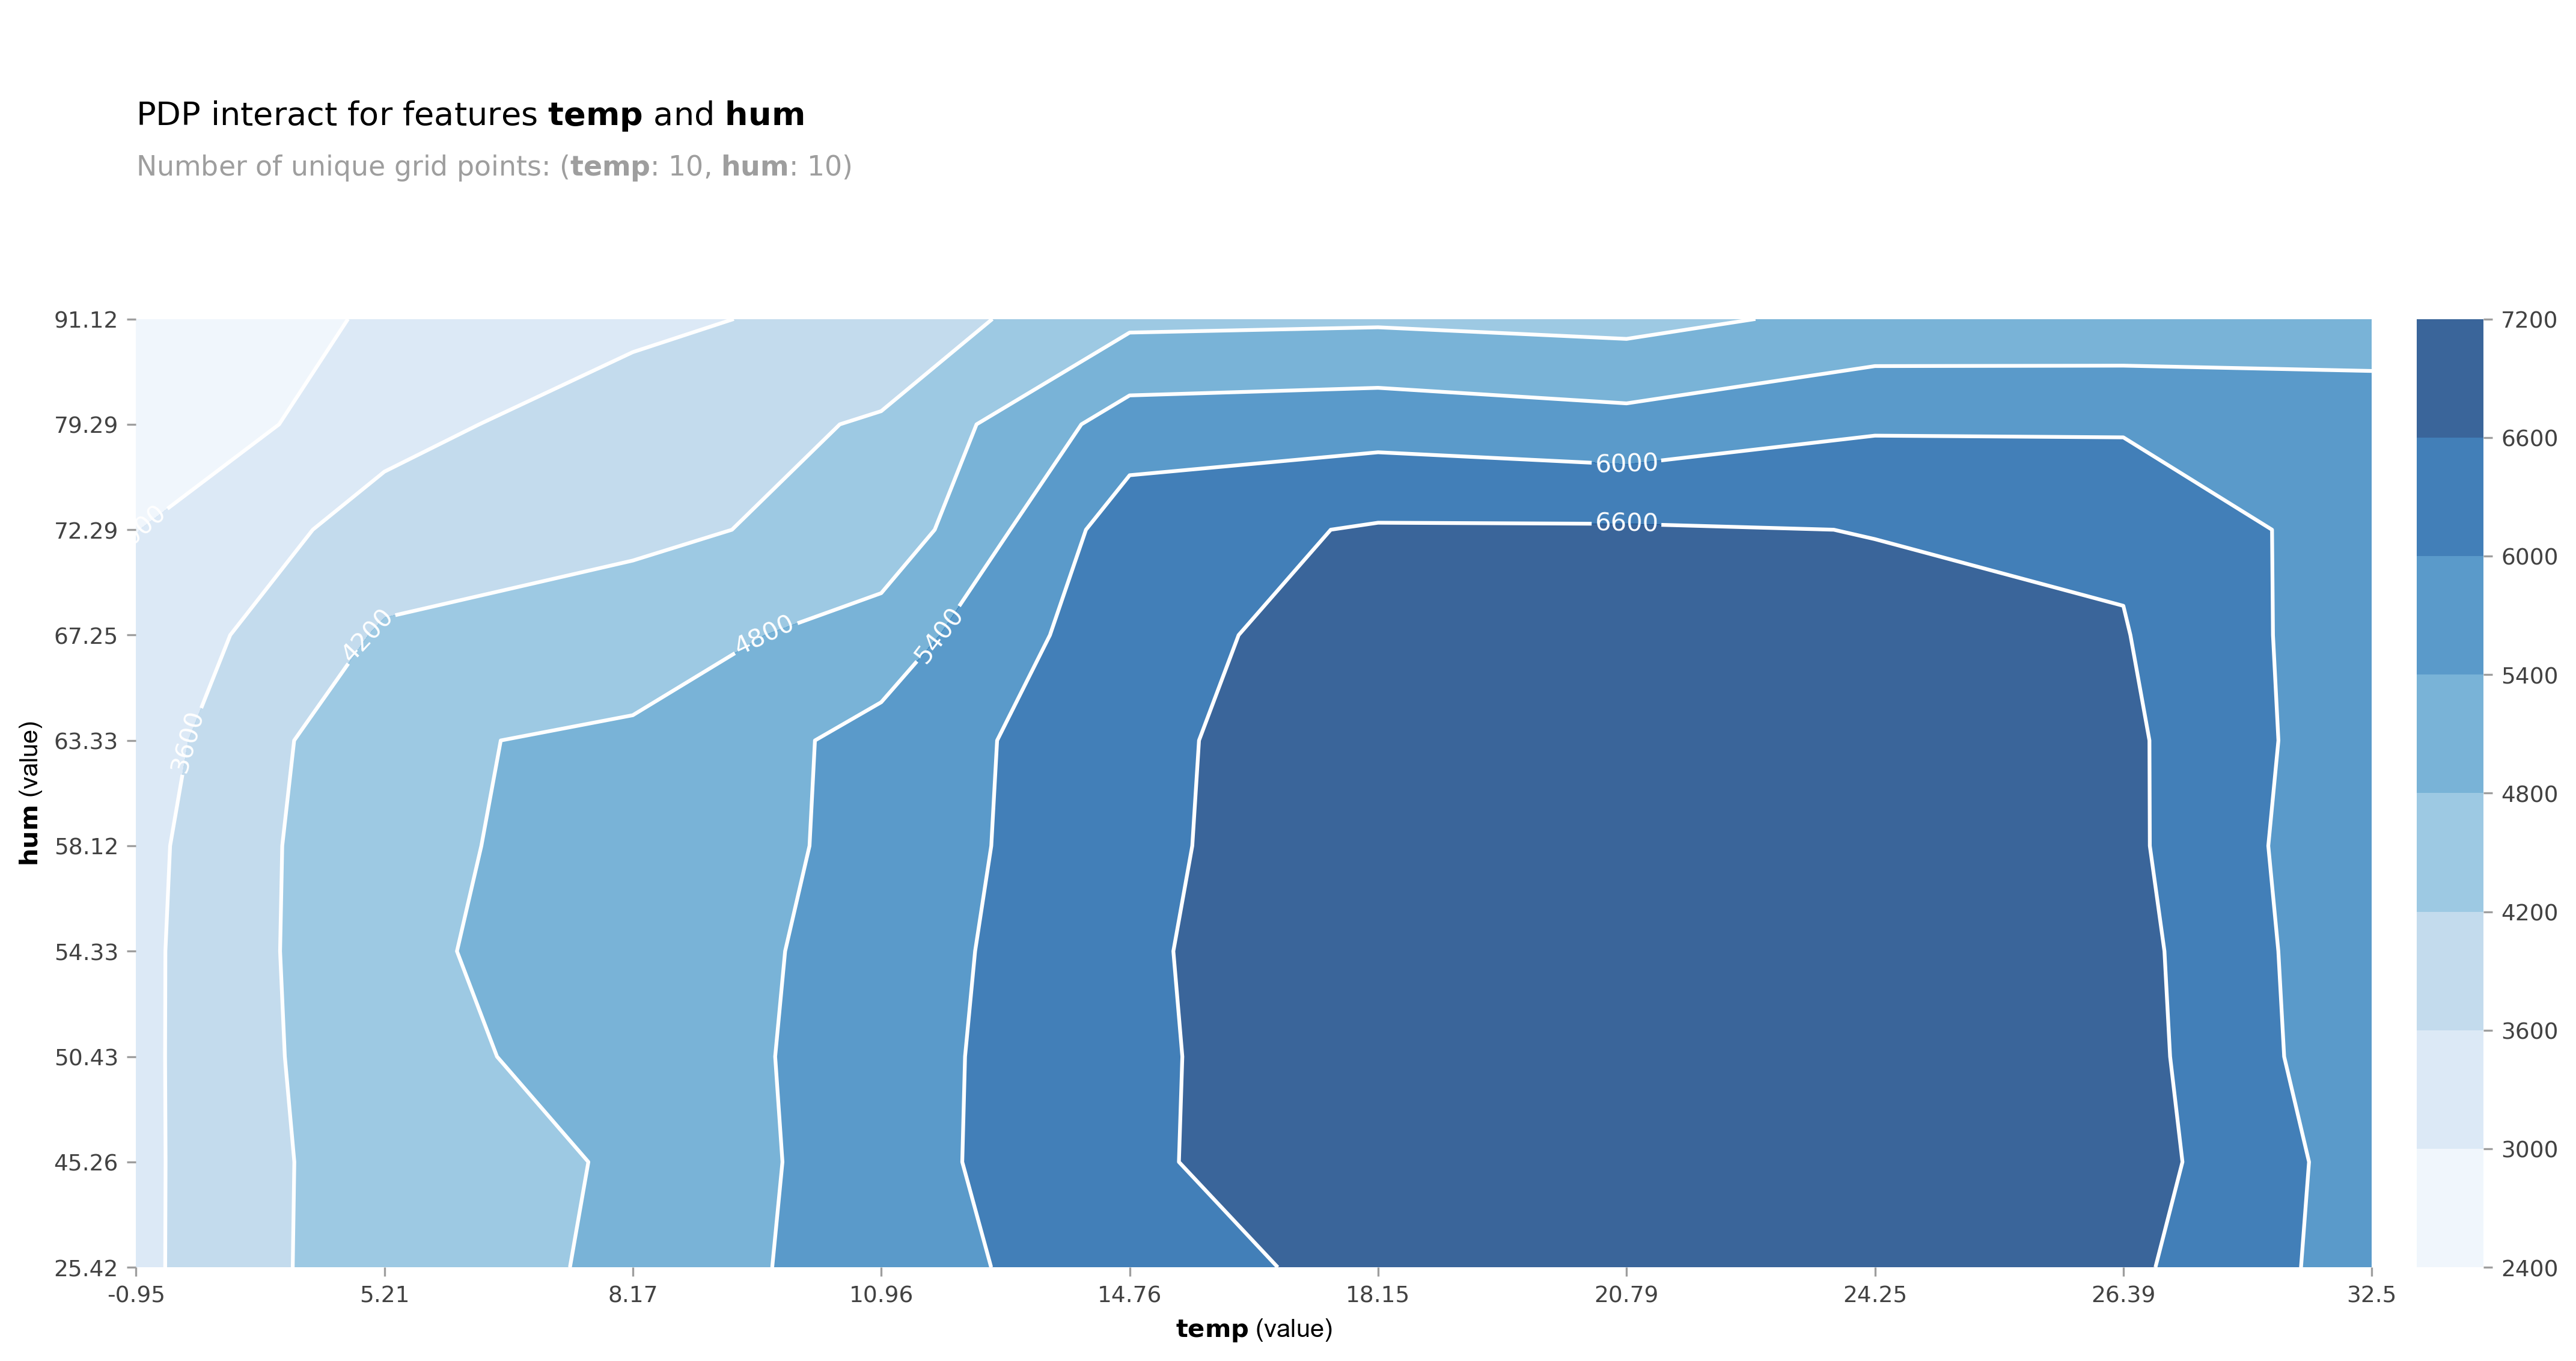

In [24]:
interact = pdp.PDPInteract(model=rf, df=X_train.copy(), model_features=X_train.columns,
                             features=['temp','hum'],
                             feature_names=['temp','hum'],
                             n_classes=0)
fig, axes = interact.plot(engine='matplotlib', plot_type='contour')

### Feature interaction

We can also measure feature interaction. For any given feature, this shows how much of the response is due to interactions or modifications by other features. **scikit-learn** currently does not have a function to calculate these, so instead, we can use the add-on package `pyartemis`. This needs to be installed using `pip`:

*Just a note of caution: I had some issues installing this at first, so you may want to skip this,*

```
pip install -U pyartemis
```



If you have successfully installed this, we can load the function `FriedmanHStatisticMethod`. We instantiate this (as with the model) and then use `fit` to run it with the data. Note that this can be computationally expensive for larger datasets, and you can often approximate the results by taking a subset of observations

In [25]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod

h_stat = FriedmanHStatisticMethod(normalized=False)
h_stat.fit(rf, X_train)

ONow we can plot the interaction scores. These are the total interaction scores, i.e. the proportion of the response modified by all the other features

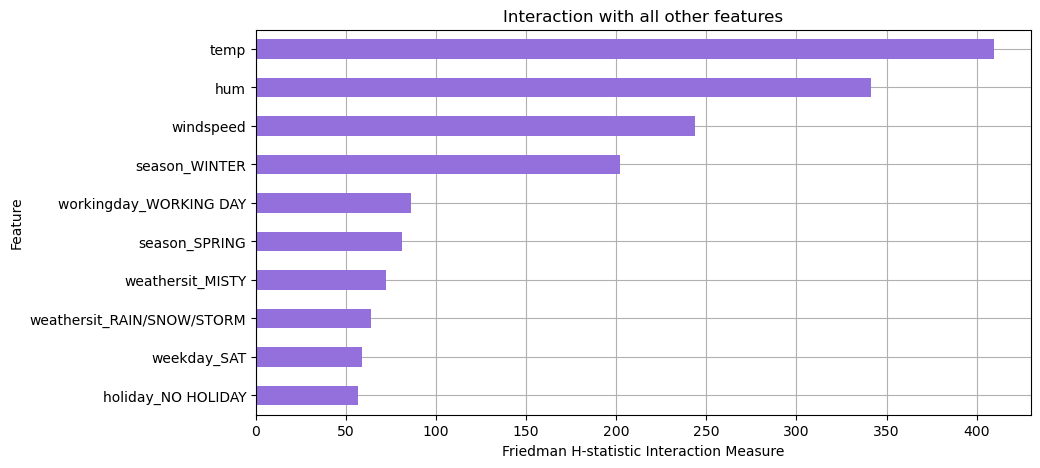

In [26]:
# Overall interaction plot
fig, ax = plt.subplots(figsize=(10, 5))
h_stat.plot(vis_type='bar_chart_ova',ax=ax)

For the bike data, approximately 35% of the temperature drive variation in rental numbers is due to interactions with other features We can break this down further by looking at the two-way interactions - this gives the proportion of the temperature response that is modified by each of the other features. Here, the top pairwise interaction is between humidity and windspeed. 

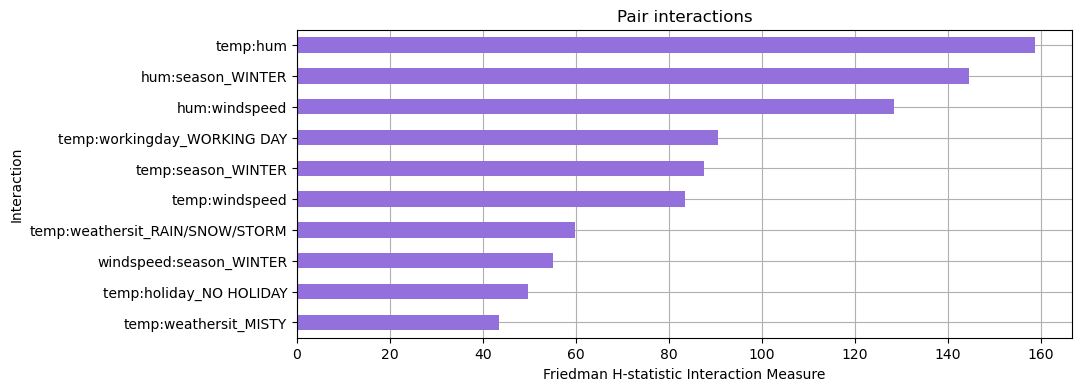

In [27]:
# Pairwise h-stat
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot(vis_type='bar_chart',ax=ax)

We can then visualize this using a 2D PD plot (not too surprisingly, rentals are lower on humid days with low wind speed)

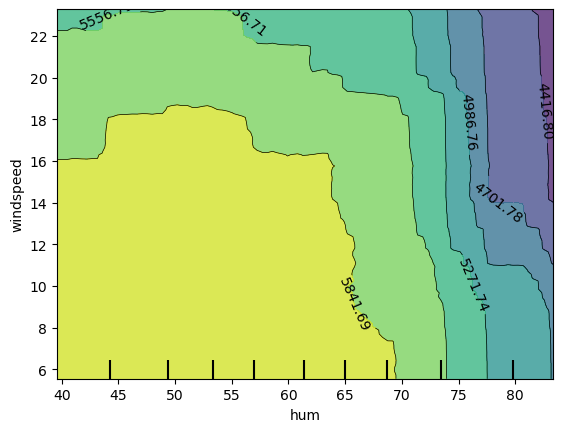

In [28]:
PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, [['hum','windspeed']])

The **pyartemis** package also allows you to plot heatmaps that integrate both the importance and interactions in a single figure. To get this, simply call the `plot` method with no arguments. Here the diagonal values show the importance (green) and the off-diagonal values show the interaction (purple)

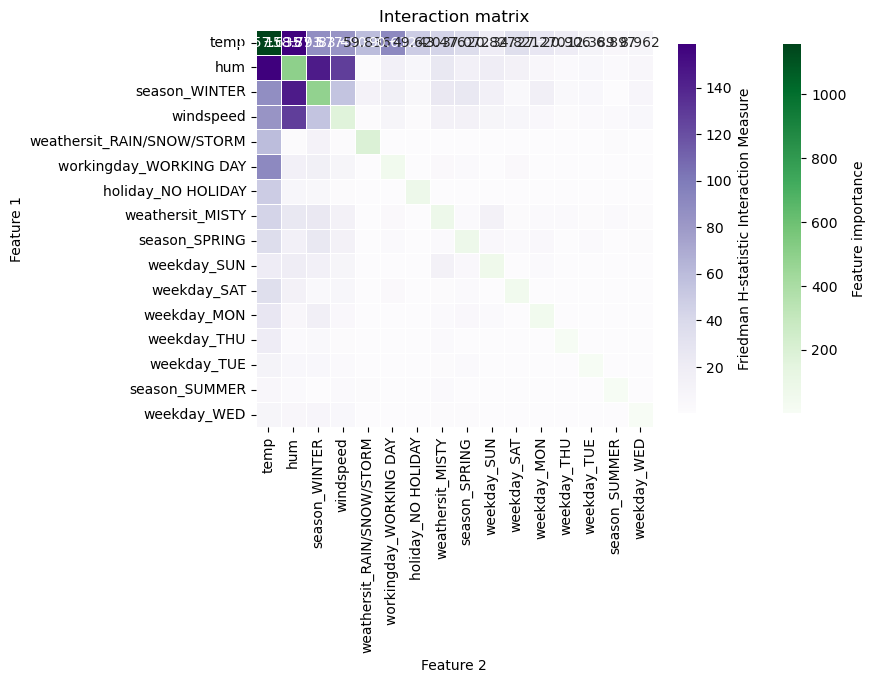

In [29]:
# Interaction heatmap
h_stat.plot()

## Local measures

We'll now look at methods for local interpretation. These methods explore how the model predicts for an individual observation. For the bike data, an individual observation is a single day of bike rentals, so these methods help shed some light on the factors driving rental numbers for any given day:

### Individual conditional expectancy (ICE) plots

We'll start with ICE plots. These are similar to partial dependency plots, as they show the changing response to a given feature. The difference is that these show this response for each individual observation. These use the same function as before (`PartialDependenceDisplay`), but we set the type of plot to `individual`:

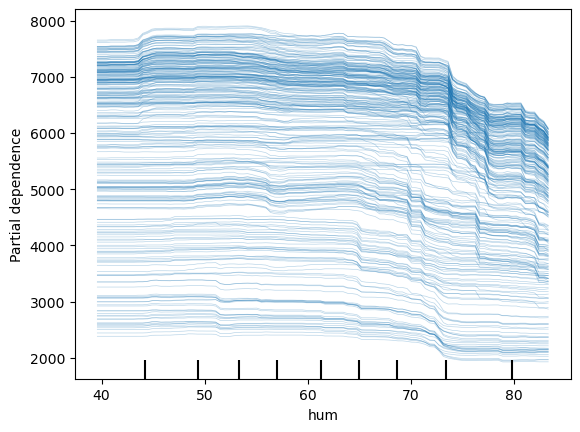

In [30]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, ['hum'], kind="individual")

Note that the partial dependency is simply the average of these individual curves, and we can add this by changing the method again to `both`:

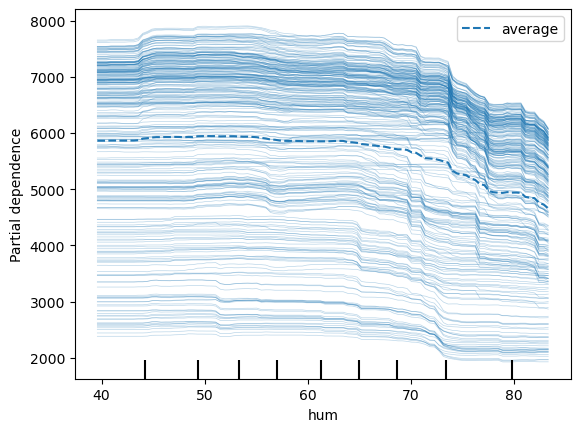

In [31]:
PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, ['hum'], kind="both")

You can also plot these with **pdpbox** by adding the argument `plot_lines=True`:

obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 218.75it/s]


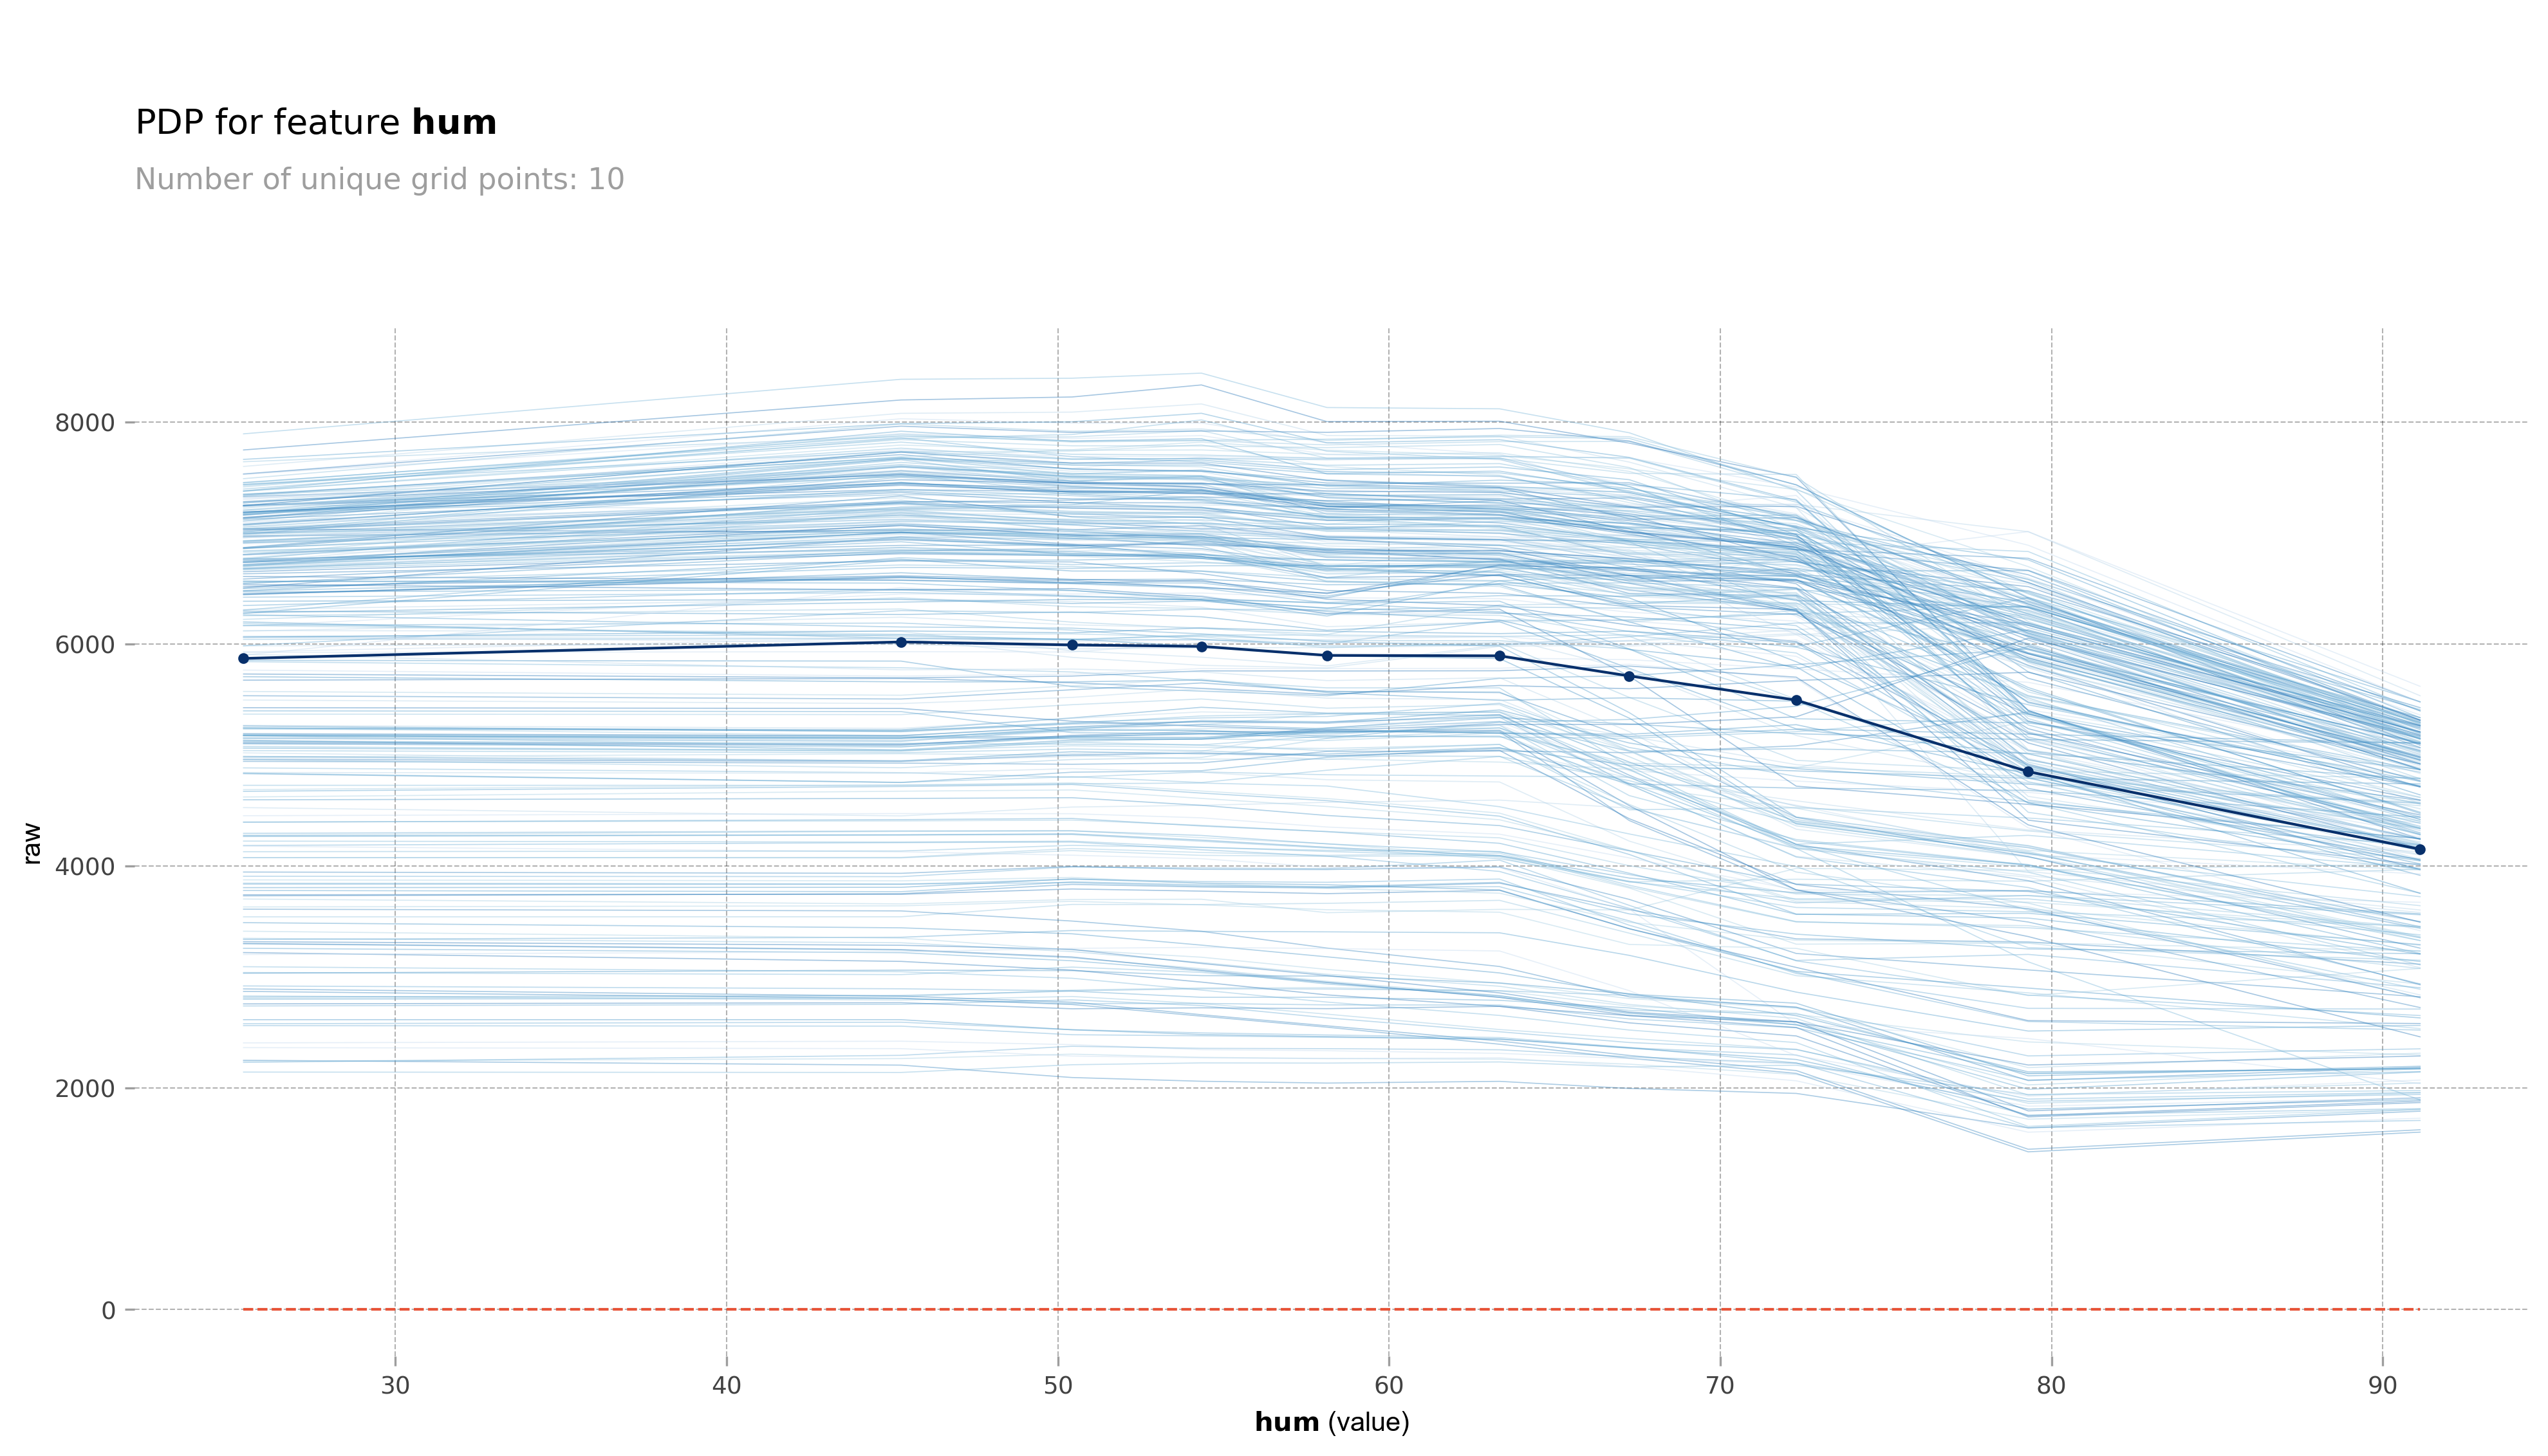

In [32]:
feature_to_plot = 'hum'
pdp_dist = pdp.PDPIsolate(model=rf, df=X_train.copy(), model_features=X_train.columns, 
                          feature=feature_to_plot, feature_name=feature_to_plot, n_classes=0)
fig, axes = pdp_dist.plot(engine='matplotlib', plot_lines=True, center=False)

And you can center these to the first point in the range. Each line now shows changes in the response relative to the value at this point. For these data, this really emphasizes the variation in rentals at high humidity - this is likely due to the interactions with temperature and wind speed noted above. 

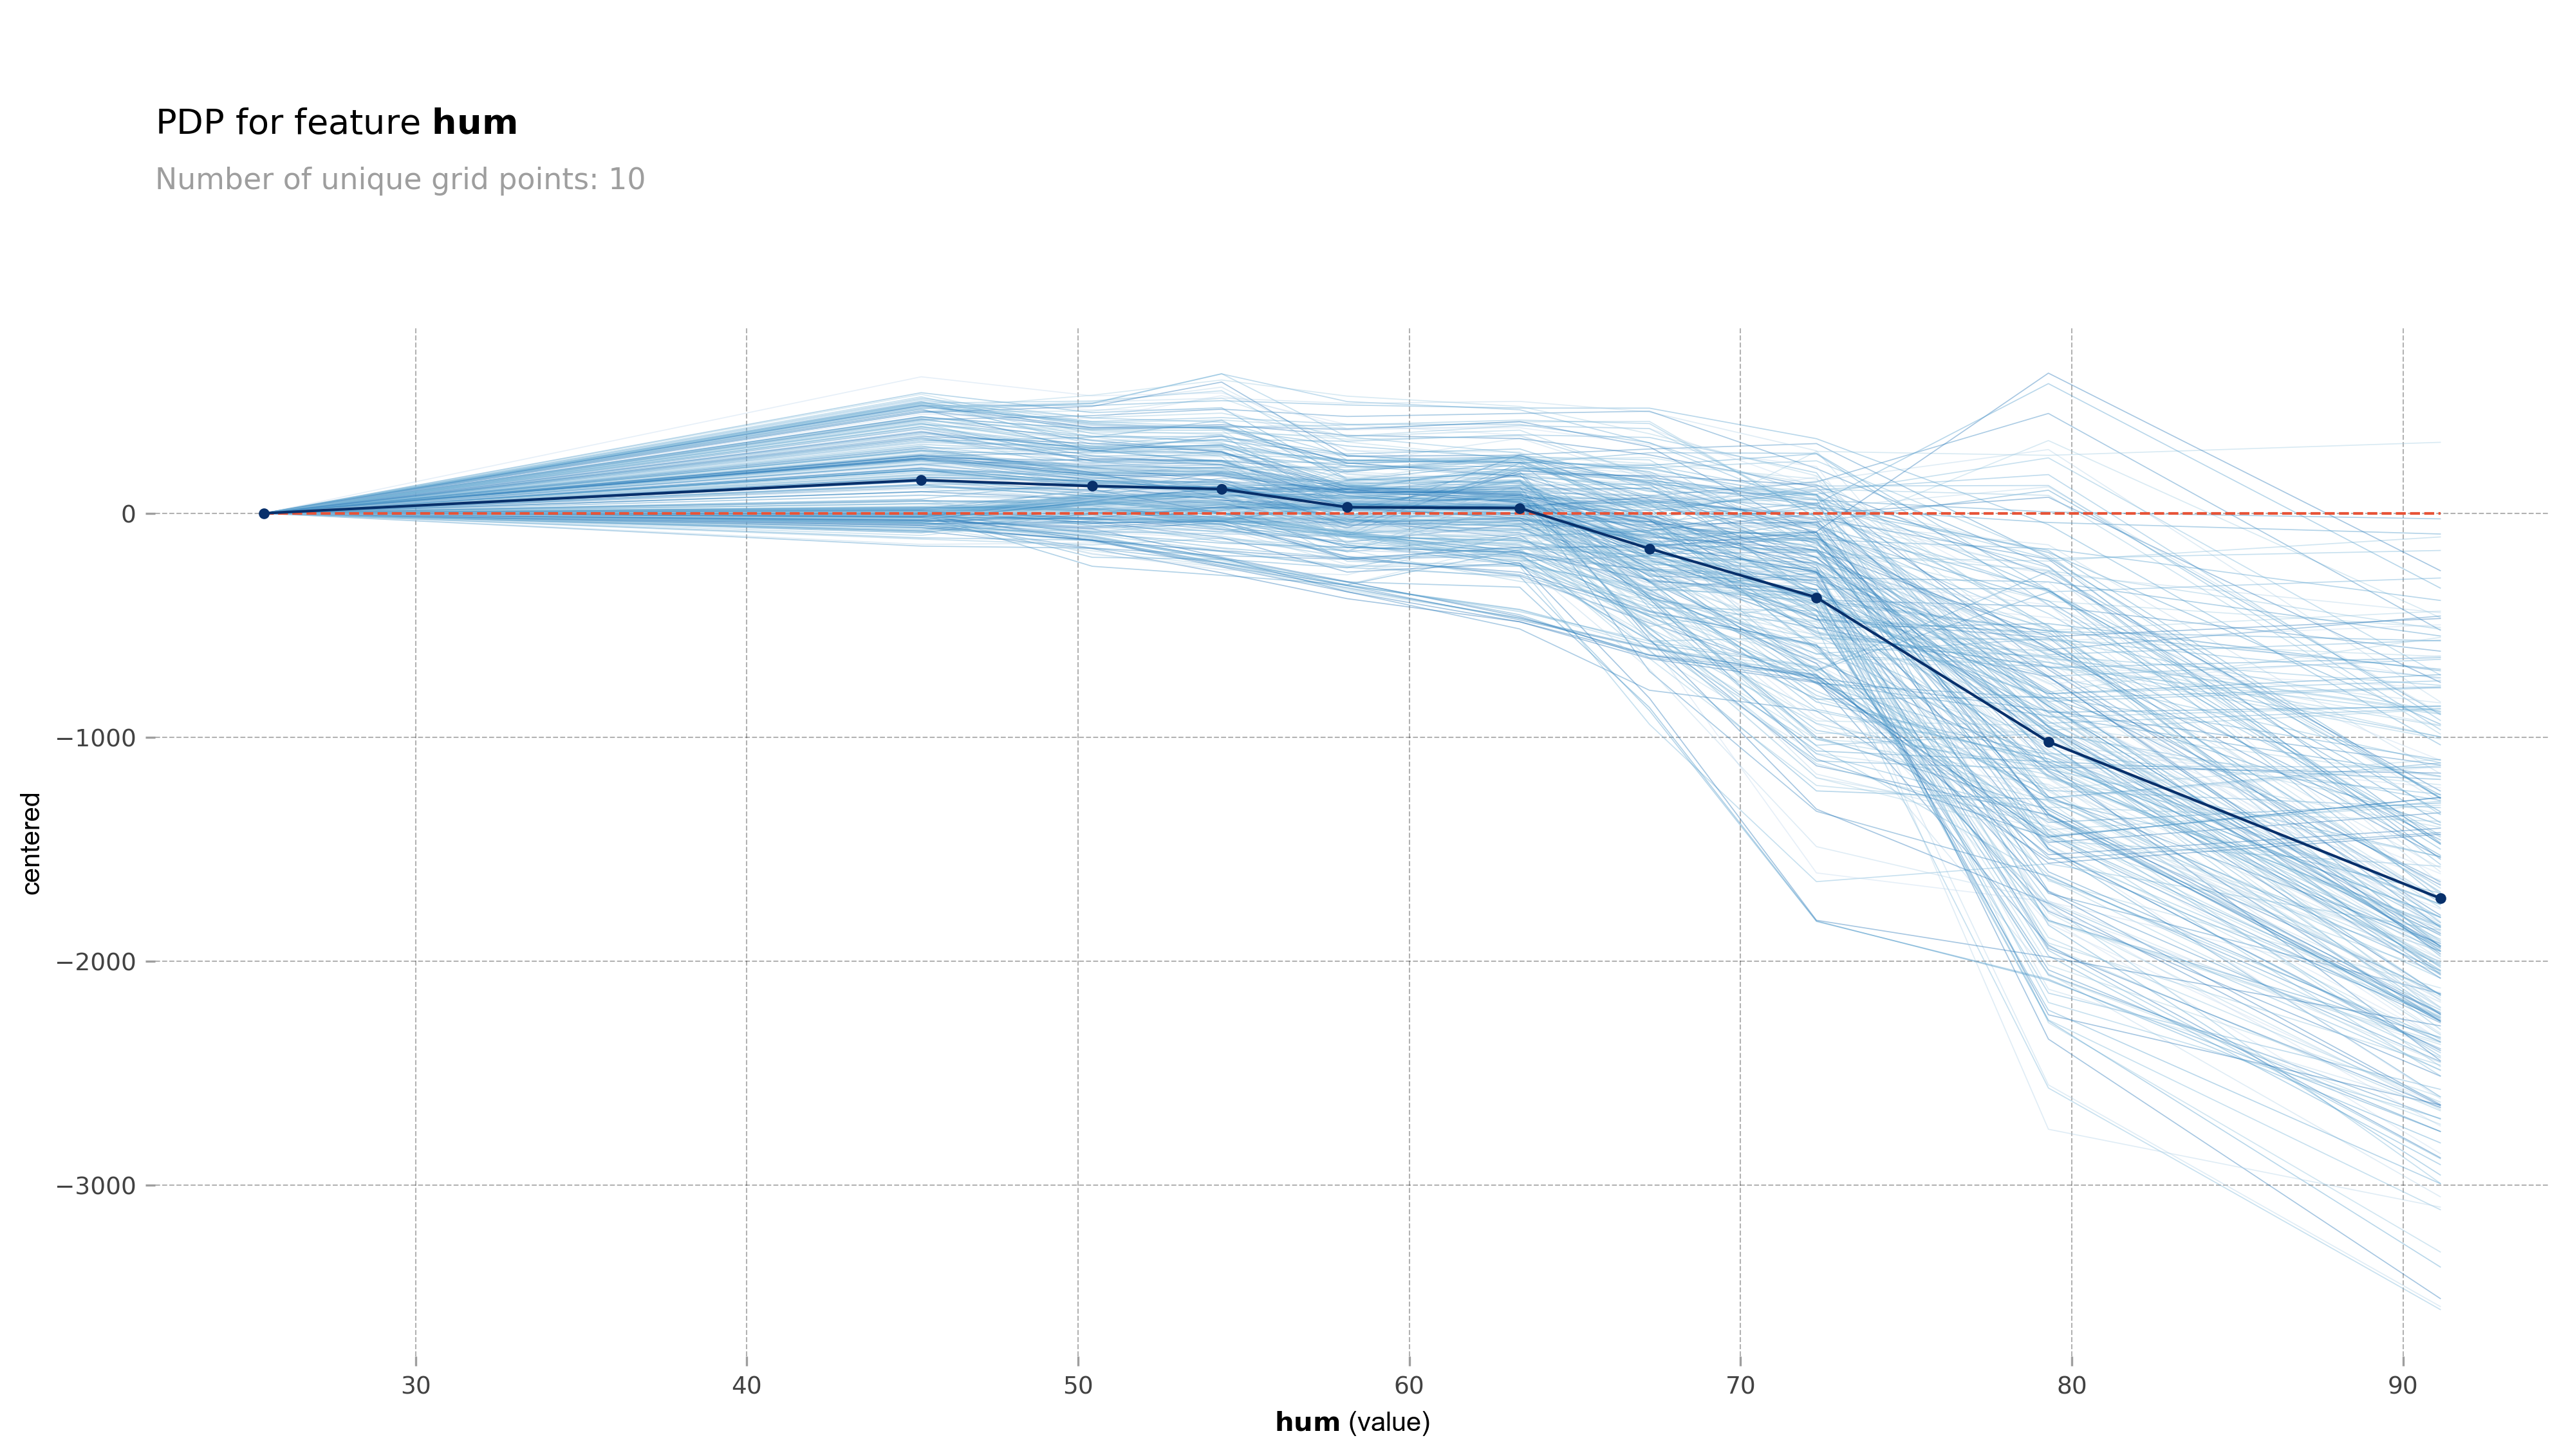

In [33]:
fig, axes = pdp_dist.plot(engine='matplotlib', plot_lines=True, center=True)

### Shapely values

We can go a little further in examining individual observations with Shapley values. These show, for an individual, the impact of each feature. So for an individual day's rentals, this would show the impact of that day's temperature, humidity, season, etc. This can be particularly useful in establishing which factors led to particularly positive (or negative) outcomes.

Let's start by finding the day with the lowest and the day with the highest rentals:

In [34]:
day_lo = y_train.values.argmin()
print(f'Day with lowest rentals : {day_lo}')
day_hi = y_train.values.argmax()
print(f'Day with highest rentals: {day_hi}')


Day with lowest rentals : 14
Day with highest rentals: 104


Now let's load the **shap** library, and set up an `explainer`. This is a simple contruct that links the model and a set of data together.

In [35]:
import shap

explainer = shap.Explainer(rf.predict, X_train)

We can now use this to calculate values for a set of observations. Here we calculate this for the training data, but you could equally calculate for test data, or entirely new observations. This will take a few seconds to run.

In [36]:
shap_values = explainer(X_train)

PermutationExplainer explainer: 293it [00:42,  5.45it/s]                         


Once run, we can start to explore the output. As this has run for the entire dataset, we can get an overview with a beeswarm plot. Each line of dots represents the responses of all the observations to a single feature. Dots that are colored red have high values of that feature, and blue dots have low values. Dots to the right of the vertical gray line have high responses (so higher rentals than average), and those to the left have lower than average values. So for the temperature feature (`temp`), we can see the following:

- It has a greater impact (wider spread of points) than other features
- Higher temperatures (red) tend to be associated with higher rentals (right)
- Lower temperatures (blue) tend to be associated with lower rentals (left)


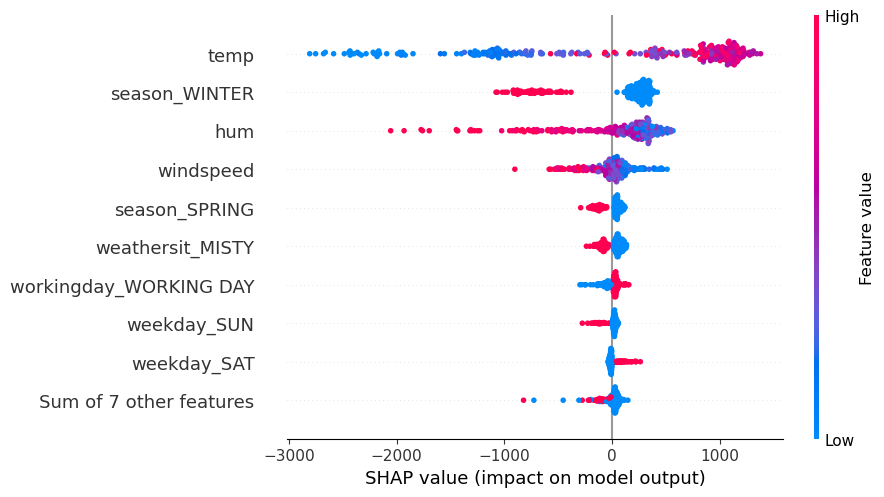

In [37]:
shap.plots.beeswarm(shap_values)

Now, let's look at the factors impacting the day with the lowest rentals:

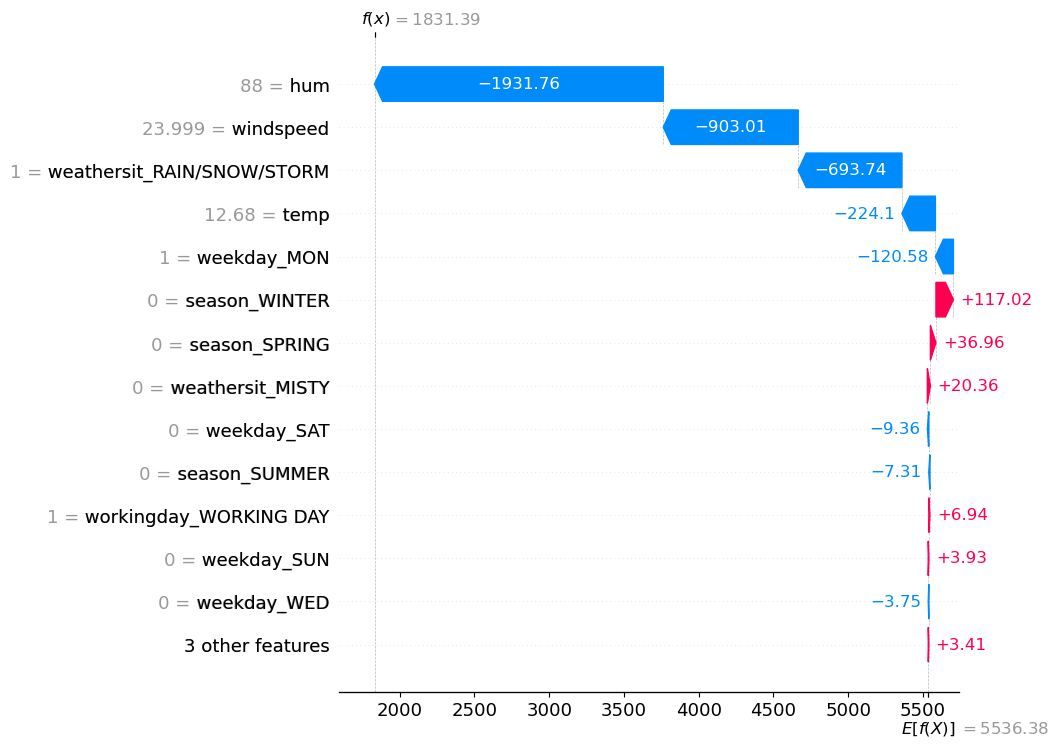

In [38]:
shap.plots.waterfall(shap_values[day_lo], max_display=14)

The combination of high humidity, high wind and rain or snow appears to be the key limiting factors. Note that temperature, despite being overall the most important factor (see above) has relatively little effect on this day.

And now let's look at the value for the day with the highest rentals:


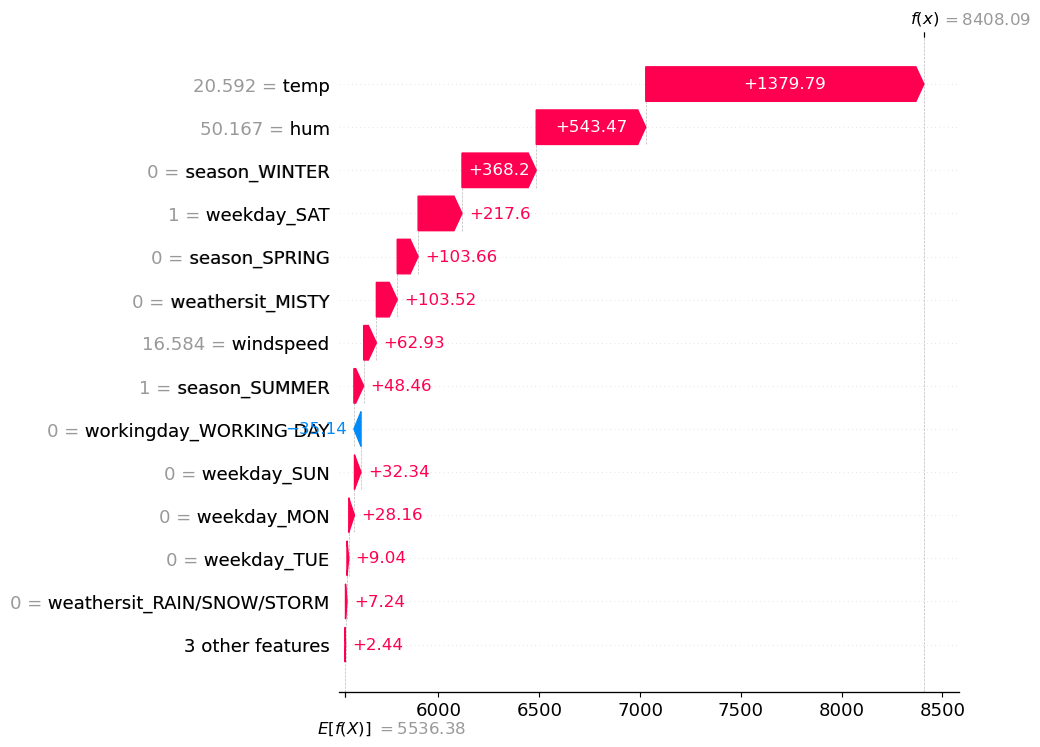

In [39]:
shap.plots.waterfall(shap_values[day_hi], max_display=14)

For this day, the combination of low humidity and warm temperatures appears to be the biggest driver.

### LIME plots

As a last approach, we'll calculate a local model using Local Interpretable Model-agnostic Explanations or LIME plots. The idea behind this method is that the 'local' or small-scale relationships between features and the target can be approximated with simple, linear models. To put this in terms of this dataset, if we take a given day in June, the changes in rentals for small variations in (say) temperature should be linear. Based on this, the method simulates a small amount of artificial data around the observation (i.e. minor variations in temperature, humidity, etc), and then fits a simple model. This simple model is usually built in a way that allows it to select only the factors that are meaningful for that observation. Let's fit this now with a single day (day 100):

In [40]:
import lime
import lime.lime_tabular

In [41]:
explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns,
        mode='regression'
    )

In [42]:
instance = X_train.iloc[100]
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=rf.predict,
    num_features=5
)

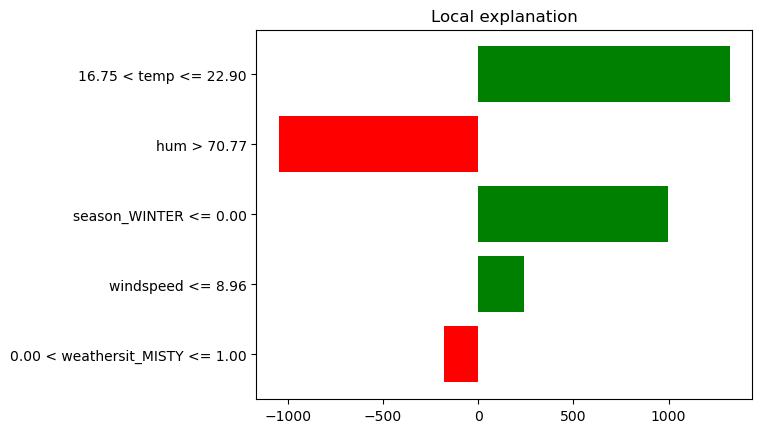

In [43]:
fig = explanation.as_pyplot_figure()
plt.show()

On this day, the warm weather increased rentals, and the high humidity decreased them.

## Exercise

In a previous lab, we built a simple linear model of house prices using the data set (*Housing_Price_Data.csv*). For this exercise you will make a new model based on a random forest (or boosted regression tree if you;d prefer) and explore it using interpretable machine learning methods. You will need to do the following:

- Load and preprocess the data. Use the `price` variable as the target. Remember to log transform the area and price variables and one-hot encode the categorical variables (see lab 2 for code)
- Split this dataset into training and testing and build a random forest or boosted regression tree
- Plot the variable importance scores using the code in this lab (lab5)
- Plot a partial dependency curve for the effect of area
- [GEOG6160 Students]: plot ICE curves for the effect of area
- [GEOG6160 Students]: calculate and plot Shapley values for two observations (e.g. the cheapest and most expensive house)

Use a new notebook to record your answers and output. These should be submitted to Canvas by February 12th. Please use the following naming convention: `Lab05_lastname.ipynb`.


# Appendix 1: Bike rental dataset

Bike rental dataset from https://christophm.github.io/interpretable-ml-book/bike-data.html:

-   `season`: The season, either spring, summer, fall or winter.
-   `year`: The year, either 2011 or 2012.
-   `mnth`: The month
-   `holiday`: Indicator whether the day was a holiday or not.
-   `weekday`: Day of week
-   `workingday`: Indicator whether the day was a working day or weekend.
-   `weathersit`: The weather situation on that day. One of:
    -   clear, few clouds, partly cloudy, cloudy
    -   mist + clouds, mist + broken clouds, mist + few clouds, mist, light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
    -   heavy rain + ice pallets + thunderstorm + mist, snow + mist
-   `temp`: Temperature in degrees Celsius.
-   `hum`: Relative humidity in percent (0 to 100).
-   `windspeed`: Wind speed in km per hour.
-   `count`: Count of bicycles including both casual and registered users. The count is used as the target in the regression task.
-   `days_since_2011`: Number of days since the 01.01.2011 (the first day in the dataset). This feature was introduced to take account of the trend over time.